In [1]:
import pandas as pd
import numpy as np
import random
from catboost import CatBoostRegressor

# Глобальная фиксация для всех библиотек
SEED = 322
random.seed(SEED)
np.random.seed(SEED)

def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

# 1. ЗАГРУЗКА
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train[train['price_p05'] > 0]
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 2. FEATURE ENGINEERING
def create_smart_features(df, train_ref=None):
    if train_ref is not None:
        prod_price_map = train_ref.groupby('product_id')['price_p05'].mean().to_dict()
        df['global_prod_avg'] = df['product_id'].map(prod_price_map)
        
        cat_price_map = train_ref.groupby('third_category_id')['price_p05'].mean().to_dict()
        df['global_cat_avg'] = df['third_category_id'].map(cat_price_map)
        
        for col in ['management_group_id', 'first_category_id', 'third_category_id']:
            df[f'std_p05_{col}'] = df[col].map(train_ref.groupby(col)['price_p05'].std().to_dict())
            df[f'std_p95_{col}'] = df[col].map(train_ref.groupby(col)['price_p95'].std().to_dict())
            
    cat_stores_map = df.groupby('third_category_id')['n_stores'].transform('mean')
    df['store_density_ratio'] = df['n_stores'] / (cat_stores_map + 1e-6)
    df['temp_hum_index'] = df['avg_temperature'] * (df['avg_humidity'] / 100)
    df['category_breadth'] = df.groupby(['dt', 'third_category_id'])['product_id'].transform('nunique')
    
    return df

train = create_smart_features(train, train_ref=train)
test = create_smart_features(test, train_ref=train)

# 3. ЦИКЛИЧЕСКИЕ ПРИЗНАКИ
def add_cyclical_features(df):
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 4. СПИСОК ПРИЗНАКОВ
cat_features = ['management_group_id', 'first_category_id', 'activity_flag']
features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year', 'month_sin', 'month_cos',
    'global_prod_avg', 'global_cat_avg', 'store_density_ratio',
    'temp_hum_index', 'category_breadth'
] 

std_cols = [c for c in train.columns if 'std_p' in c and 'dow' not in c and 'second' not in c]
features += std_cols + cat_features

train[features] = train[features].fillna(train[features].mean(numeric_only=True))
test[features] = test[features].fillna(train[features].mean(numeric_only=True))

# 5. ВАЛИДАЦИЯ / КАЛИБРОВКА
train_parts, val_parts = [], []
for _, group in train.groupby('dt'):
    group = group.sample(frac=1, random_state=SEED).reset_index(drop=True)
    split_idx = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

train_part = pd.concat(train_parts)
val_part = pd.concat(val_parts)

# ПАРАМЕТРЫ ОТ OPTUNA (Trial 67)
params_low = {
    'iterations': 3000,
    'learning_rate': 0.031781536502931716,
    'depth': 10,
    'l2_leaf_reg': 3.141747318300566,
    'random_strength': 2.8093237552762096,
    'bagging_temperature': 0.8872049532720385,
    'min_data_in_leaf': 72,
    'random_seed': SEED,
    'loss_function': 'MAE',
    'early_stopping_rounds': 150,
    'verbose': 100
}

params_high = {
    'iterations': 3000,
    'learning_rate': 0.023877719346590182,
    'depth': 10,
    'l2_leaf_reg': 3.2292916356384764,
    'random_strength': 2.4470158919621636,
    'bagging_temperature': 0.5190219570850714,
    'min_data_in_leaf': 50,
    'random_seed': SEED,
    'loss_function': 'MAE',
    'early_stopping_rounds': 150,
    'verbose': 100
}

print("Обучение моделей на train_part...")
model_low = CatBoostRegressor(**params_low)
model_high = CatBoostRegressor(**params_high)

model_low.fit(train_part[features], train_part['price_p05'], 
              eval_set=(val_part[features], val_part['price_p05']), 
              cat_features=cat_features, use_best_model=True)

model_high.fit(train_part[features], train_part['price_p95'], 
               eval_set=(val_part[features], val_part['price_p95']), 
               cat_features=cat_features, use_best_model=True)

# --- РАЗДЕЛЬНЫЙ ПОИСК ALPHA ---
print("\nПоиск оптимальных раздельных alpha на val_part...")
calib_preds_low = model_low.predict(val_part[features])
calib_preds_high = model_high.predict(val_part[features])

nonconf_low = calib_preds_low - val_part['price_p05']
nonconf_high = val_part['price_p95'] - calib_preds_high

best_iou = -1
best_q = (0, 0)
alphas_to_test = np.linspace(0.1, 0.9, 81)

for al in alphas_to_test:
    ql = np.quantile(nonconf_low, 1 - al/2)
    p05_corr = calib_preds_low - ql
    for ah in alphas_to_test:
        qh = np.quantile(nonconf_high, 1 - ah/2)
        p95_corr = calib_preds_high + qh
        p95_corr_safe = np.maximum(p95_corr, p05_corr + 0.001)
        
        score = calculate_iou(val_part['price_p05'].values, val_part['price_p95'].values, p05_corr, p95_corr_safe)
        if score > best_iou:
            best_iou = score
            best_q = (ql, qh)

q_low, q_high = best_q
print(f"Лучший результат на валидации: IoU={best_iou:.4f}")

# 6. ФИНАЛЬНОЕ ОБУЧЕНИЕ НА ВСЕМ TRAIN
print("\nФинальное обучение на полном датасете...")
final_low_params = params_low.copy()
final_low_params['iterations'] = model_low.get_best_iteration() + 1
final_low_params.pop('early_stopping_rounds', None)

final_high_params = params_high.copy()
final_high_params['iterations'] = model_high.get_best_iteration() + 1
final_high_params.pop('early_stopping_rounds', None)

final_low = CatBoostRegressor(allow_writing_files=False, **final_low_params)
final_high = CatBoostRegressor(allow_writing_files=False, **final_high_params)

final_low.fit(train[features], train['price_p05'], cat_features=cat_features, verbose=100)
final_high.fit(train[features], train['price_p95'], cat_features=cat_features, verbose=100)

# 7. ПРЕДСКАЗАНИЕ
print("Генерация сабмита...")
test['price_p05'] = final_low.predict(test[features]) - q_low
test['price_p95'] = final_high.predict(test[features]) + q_high
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission_v5_optuna_final.csv', index=False)
print("Готово!")

Обучение моделей на train_part...
0:	learn: 0.1477435	test: 0.1394269	best: 0.1394269 (0)	total: 164ms	remaining: 8m 13s
100:	learn: 0.0872178	test: 0.0933732	best: 0.0933732 (100)	total: 8.23s	remaining: 3m 56s
200:	learn: 0.0819100	test: 0.0925951	best: 0.0925203 (176)	total: 14.5s	remaining: 3m 22s
300:	learn: 0.0789117	test: 0.0925780	best: 0.0925203 (176)	total: 19.4s	remaining: 2m 53s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.09252032664
bestIteration = 176

Shrink model to first 177 iterations.
0:	learn: 0.0997019	test: 0.0937119	best: 0.0937119 (0)	total: 49.6ms	remaining: 2m 28s
100:	learn: 0.0836505	test: 0.0880646	best: 0.0880343 (70)	total: 5.17s	remaining: 2m 28s
200:	learn: 0.0791268	test: 0.0882188	best: 0.0880343 (70)	total: 10.5s	remaining: 2m 25s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.08803432035
bestIteration = 70

Shrink model to first 71 iterations.

Поиск оптимальных раздельных alpha на val_part...
Лучший ре

In [5]:
import pandas as pd
import numpy as np
import catboost
import sklearn

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"CatBoost version: {catboost.__version__}")
# Если используете sklearn для метрик или сплитов
print(f"Sklearn version: {sklearn.__version__}")

Pandas version: 2.2.3
NumPy version: 2.1.3
CatBoost version: 1.2.8
Sklearn version: 1.6.1


In [2]:
# идеи - признаки через стандартные отклонения и т д в разных разрезах?
# анализ текущих ошибок модели на валидации
# замена валидации на OOT ?
# обучение нейросети + conformal + кастомный лосс Pinball + coverage penalty для нейросети 

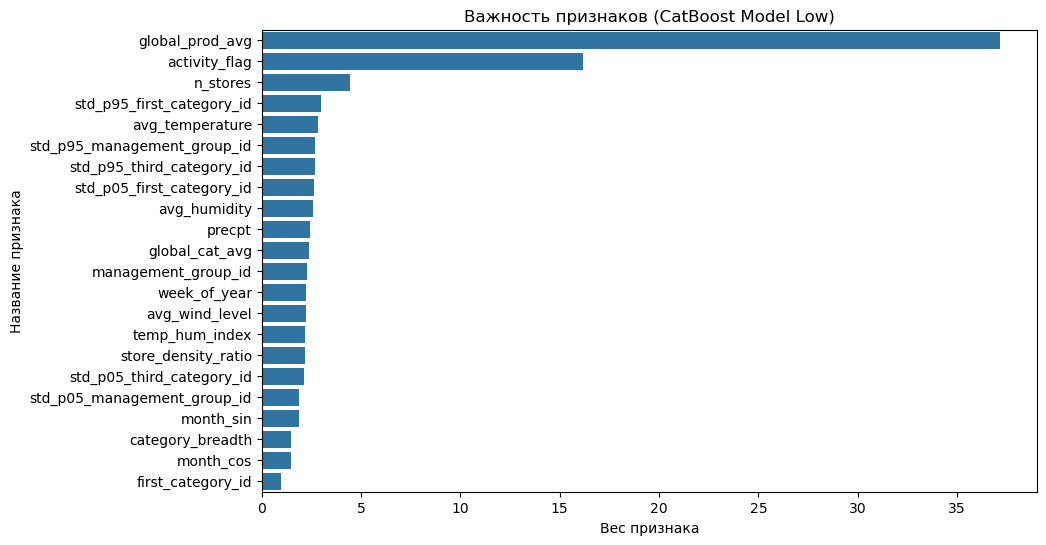

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()